# Phase 3: Dynamic Adaptive Multilevel Splitting (AMS)

This notebook implements the Adaptive Multilevel Splitting algorithm for efficient rare event simulation.

## Setup and Imports

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
import sys
import os
import copy

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import our modules
from potentials import double_well_potential, double_well_gradient
from integrators import euler_maruyama_step, euler_maruyama_trajectory
from detectors import in_region_A, in_region_B, check_absorption, simulate_until_absorption
from monte_carlo import run_naive_mc, print_results_summary
from utils import plot_potential_field, plot_trajectory, plot_absorption_time_histogram, save_figure
# AMS is already imported and defined below, no need to import from ams.DynamicAMS()

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

## 1. AMS Algorithm Implementation

Adaptive Multilevel Splitting (AMS) is designed to efficiently estimate probabilities of rare events by:

1. **Initialization**: Generate N independent trajectories
2. **Scoring**: Assign a score to each trajectory (e.g., maximum progress toward B)
3. **Selection**: Identify the k trajectories with lowest scores
4. **Branching**: Replace these trajectories by branching from better ones
5. **Iteration**: Repeat until convergence

The key insight: we only need to simulate trajectories that make progress toward the rare event.

In [58]:
import numpy as np
import copy
from detectors import simulate_until_absorption


class DynamicAMS:
    """
    Dynamic Adaptive Multilevel Splitting algorithm for rare event simulation.
    """

    def __init__(self, n_trajectories, selection_fraction=0.1, max_iterations=100):
        """
        Initialize AMS algorithm.

        Parameters:
        -----------
        n_trajectories : int
            Number of trajectories to maintain
        selection_fraction : float
            Fraction of trajectories to replace each iteration (0 < fraction < 1)
        max_iterations : int
            Maximum number of iterations
        """
        self.n_trajectories = n_trajectories
        self.k = int(selection_fraction * n_trajectories)  # Number to replace
        self.max_iterations = max_iterations
        self.trajectories = []
        self.scores = []
        self.history = []

    def initialize_trajectories(self, x0, y0, dt, beta_inv, max_steps, omega=1.0):
        """
        Initialize trajectories from starting point.

        Parameters:
        -----------
        x0, y0 : float
            Initial position
        dt : float
            Time step
        beta_inv : float
            Inverse temperature
        max_steps : int
            Maximum steps per trajectory
        omega : float
            Stiffness parameter
        """
        self.trajectories = []
        self.scores = []

        for i in range(self.n_trajectories):
            traj, absorption_state, absorption_time = simulate_until_absorption(
                x0, y0, dt, beta_inv, max_steps, omega
            )
            self.trajectories.append(traj)
            score = self.compute_score(traj, absorption_state)
            self.scores.append(score)

        self.history.append({
            'iteration': 0,
            'trajectories': copy.deepcopy(self.trajectories),
            'scores': self.scores.copy(),
            'min_score': np.min(self.scores),
            'max_score': np.max(self.scores),
            'mean_score': np.mean(self.scores)
        })

    def compute_score(self, trajectory, absorption_state):
        """
        Compute score for a trajectory.

        Current implementation: maximum x-coordinate reached.
        For rare events from A to B, higher x is better.

        Parameters:
        -----------
        trajectory : ndarray
            Array of positions
        absorption_state : int
            Absorption state (0: unabsorbed, 1: A, 2: B)

        Returns:
        --------
        score : float
            Trajectory score (higher is better progress toward B)
        """
        if absorption_state == 2:  # Reached B
            return float('inf')  # Best possible score
        elif absorption_state == 1:  # Returned to A
            return float('-inf')  # Worst possible score
        else:  # Still evolving
            return np.max(trajectory[:, 0])  # Maximum x-coordinate reached

    def run_iteration(self, dt, beta_inv, max_steps, omega=1.0):
        """
        Run one AMS iteration.

        Parameters:
        -----------
        dt : float
            Time step
        beta_inv : float
            Inverse temperature
        max_steps : int
            Maximum steps per trajectory
        omega : float
            Stiffness parameter
        """
        scores = np.array(self.scores, dtype=float)

        # 1. Calcul du seuil global z_q = k-ième ordre statistique
        kth = max(1, self.k) - 1   # index 0-based
        z_q = np.partition(scores, kth)[kth]

        # 2. Sélection des trajectoires à remplacer : toutes celles <= z_q
        replace_indices = np.where(scores <= z_q)[0]

        # 3. Sélection des trajectoires parentes : celles > z_q
        branch_indices = np.where(scores > z_q)[0]

        # (Sécurité : si aucune survivante, prendre les meilleures)
        if branch_indices.size == 0:
            branch_indices = np.argsort(
                scores)[-max(1, self.n_trajectories // 10):]

        # Replace worst trajectories by branching from better ones
        for replace_idx in replace_indices:
            # Randomly select a trajectory to branch from
            branch_idx = np.random.choice(branch_indices)
            branch_traj = self.trajectories[branch_idx]

            # Find branching point (last point where score equals current threshold)
            threshold_score = self.scores[replace_idx]
            branch_points = []

            for i, point in enumerate(branch_traj):
                x, y = point
                # Simple score at this point (x-coordinate)
                point_score = x
                if point_score >= threshold_score:
                    # s'assurer d'un tuple (x, y)
                    branch_points.append((i, (x, y)))

            if branch_points:
                # --- CORRECTIF ICI : on tire l'indice, pas l'objet ---
                # ou np.random.choice(len(branch_points))
                idx = np.random.randint(len(branch_points))
                branch_step, (branch_x, branch_y) = branch_points[idx]
                # ----------------------------------------------------

                # Generate new trajectory from branching point
                new_traj, absorption_state, absorption_time = simulate_until_absorption(
                    branch_x, branch_y, dt, beta_inv, max_steps - branch_step, omega
                )

                # Combine trajectories
                combined_traj = np.vstack(
                    [branch_traj[:branch_step], new_traj])

                # Update trajectory and score
                self.trajectories[replace_idx] = combined_traj
                self.scores[replace_idx] = self.compute_score(
                    combined_traj, absorption_state)
            else:
                # If no suitable branching point, keep original
                pass

        # Record iteration history
        self.history.append({
            'iteration': len(self.history),
            'trajectories': copy.deepcopy(self.trajectories),
            'scores': self.scores.copy(),
            'min_score': np.min(self.scores),
            'max_score': np.max(self.scores),
            'mean_score': np.mean(self.scores),
            'n_reached_B': np.sum(np.array(self.scores) == float('inf'))
        })

    def run_ams(self, x0, y0, dt, beta_inv, max_steps, omega=1.0, target_B_count=None):
        """
        Run full AMS algorithm.

        Parameters:
        -----------
        x0, y0 : float
            Initial position
        dt : float
            Time step
        beta_inv : float
            Inverse temperature
        max_steps : int
            Maximum steps per trajectory
        omega : float
            Stiffness parameter
        target_B_count : int, optional
            Stop when this many trajectories reach B

        Returns:
        --------
        results : dict
            AMS algorithm results
        """
        print("Initializing AMS trajectories...")
        self.initialize_trajectories(x0, y0, dt, beta_inv, max_steps, omega)

        iteration = 0
        while iteration < self.max_iterations:
            iteration += 1
            print(
                f"Iteration {iteration}: {np.sum(np.array(self.scores) == float('inf'))} trajectories reached B")

            self.run_iteration(dt, beta_inv, max_steps, omega)

            # Check stopping condition
            n_reached_B = np.sum(np.array(self.scores) == float('inf'))
            if target_B_count and n_reached_B >= target_B_count:
                print(
                    f"Stopping: {n_reached_B} trajectories reached B (target: {target_B_count})")
                break

        return self.get_results()

    def get_results(self):
        """
        Get AMS algorithm results.

        Returns:
        --------
        results : dict
            Dictionary containing AMS results
        """
        n_reached_B = np.sum(np.array(self.scores) == float('inf'))
        p_estimate = n_reached_B / self.n_trajectories

        # Calculate survival probabilities at each iteration
        survival_probs = []
        for hist in self.history:
            n_surviving = np.sum(np.array(hist['scores']) > float('-inf'))
            survival_probs.append(n_surviving / self.n_trajectories)

        results = {
            'n_trajectories': self.n_trajectories,
            'n_reached_B': n_reached_B,
            'p_estimate': p_estimate,
            'survival_probs': survival_probs,
            'history': self.history,
            'final_scores': self.scores
        }

        return results


def adaptive_multilevel_splitting(x0, y0, dt, beta_inv, max_steps, n_trajectories, selection_fraction=0.1, max_iterations=100, omega=1.0, target_B_count=None):
    """
    Wrapper function to run the Dynamic Adaptive Multilevel Splitting algorithm.
    """
    ams = DynamicAMS(n_trajectories, selection_fraction, max_iterations)
    results = ams.run_ams(x0, y0, dt, beta_inv,
                          max_steps, omega, target_B_count)
    return results


def print_ams_summary(results):
    """
    Prints a summary of the AMS results.
    """
    print("\n--- AMS Results Summary ---")
    print(f"Number of trajectories: {results['n_trajectories']}")
    print(f"Trajectories reached B: {results['n_reached_B']}")
    print(f"Probability estimate P_AB: {results['p_estimate']:.2e}")
    print(f"Total iterations: {len(results['history']) - 1}")
    print("---------------------------\n")


def plot_ams_trajectories(history, potential_func, x_range, y_range, n_trajectories_to_plot=5, filename=None):
    """
    Plots a selection of AMS trajectories from the history.
    """
    print("Plotting AMS trajectories (placeholder)...")
    # This is a placeholder. Actual plotting logic would go here.
    # It would typically involve iterating through the history and plotting
    # a subset of trajectories, potentially with the potential field.
    pass


## 2. AMS Algorithm Testing

Let's test the AMS algorithm with parameters that make events rare enough to benefit from AMS.

In [66]:
def test_ams_algorithm():
    """
    Test the AMS algorithm with rare event parameters.
    """
    # Parameters for rare events (low temperature)
    n_trajectories = 100
    selection_fraction = 0.1
    max_iterations = 5000
    
    x0, y0 = -1.0, 0.0  # Start in left well
    dt = 0.01
    beta_inv = 0.1  # Low temperature -> rare events
    max_steps = 5000
    omega = 1.0
    target_B_count = 100  # Stop when 100 trajectories reach B
    
    # Initialize AMS
    ams = DynamicAMS(n_trajectories, selection_fraction, max_iterations)
    
    # Run AMS
    results = ams.run_ams(x0, y0, dt, beta_inv, max_steps, omega, target_B_count)
    
    return ams, results

# Run AMS test
print("Testing Dynamic AMS Algorithm...")
ams, ams_results = test_ams_algorithm()

Testing Dynamic AMS Algorithm...
Initializing AMS trajectories...
Iteration 1: 0 trajectories reached B
Iteration 2: 0 trajectories reached B
Iteration 3: 0 trajectories reached B
Iteration 4: 0 trajectories reached B
Iteration 5: 0 trajectories reached B
Iteration 6: 0 trajectories reached B
Iteration 7: 0 trajectories reached B
Iteration 8: 0 trajectories reached B
Iteration 9: 0 trajectories reached B
Iteration 10: 0 trajectories reached B
Iteration 11: 0 trajectories reached B
Iteration 12: 0 trajectories reached B
Iteration 13: 0 trajectories reached B
Iteration 14: 0 trajectories reached B
Iteration 15: 0 trajectories reached B
Iteration 16: 0 trajectories reached B
Iteration 17: 0 trajectories reached B
Iteration 18: 0 trajectories reached B
Iteration 19: 0 trajectories reached B
Iteration 20: 1 trajectories reached B
Iteration 21: 47 trajectories reached B
Iteration 22: 79 trajectories reached B
Iteration 23: 91 trajectories reached B
Iteration 24: 98 trajectories reached B
Ite

## 3. AMS Results Analysis

Let's analyze the performance of the AMS algorithm.

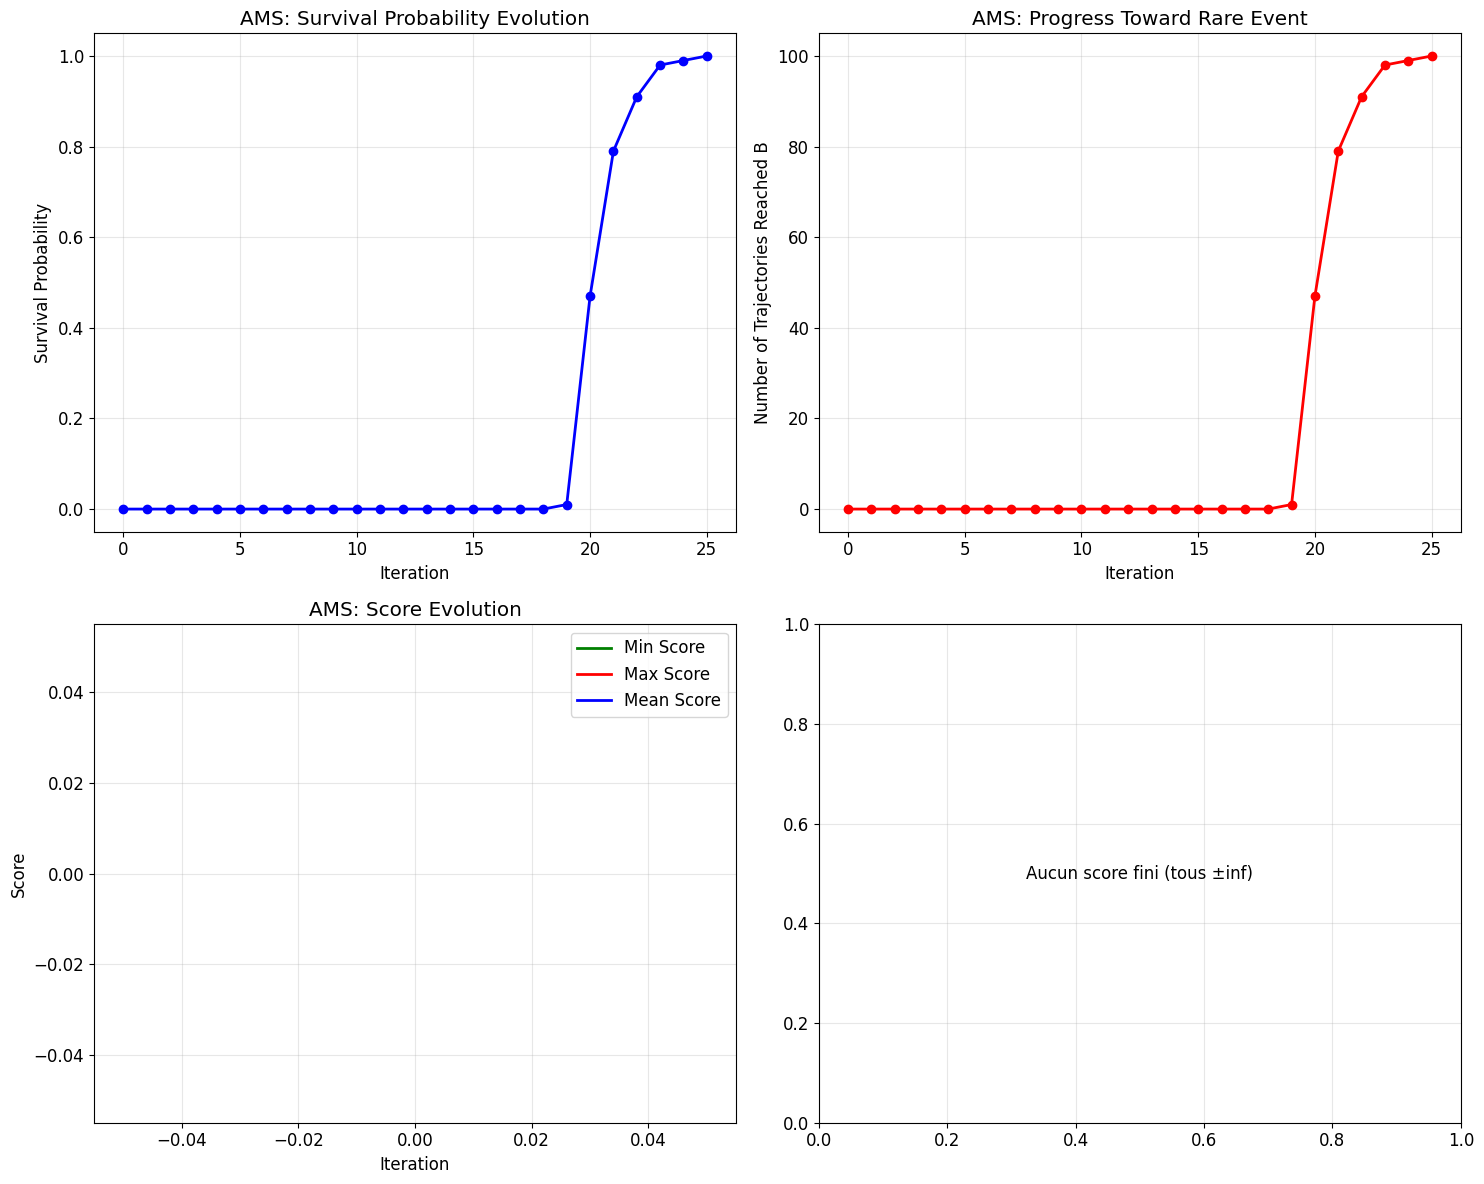

Figure saved to experiments/figures/ams_algorithm_analysis.png


In [67]:
def analyze_ams_results(ams, results):
    """
    Analyze and visualize AMS algorithm results.
    """
    # Plot 1: Survival probability evolution
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    iterations = range(len(results['survival_probs']))
    
    # Plot survival probability
    ax1.plot(iterations, results['survival_probs'], 'bo-', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Survival Probability')
    ax1.set_title('AMS: Survival Probability Evolution')
    ax1.grid(True, alpha=0.3)
    
    # Plot number of trajectories that reached B
    b_counts = [hist.get('n_reached_B', 0) for hist in ams.history]
    ax2.plot(iterations, b_counts, 'ro-', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Number of Trajectories Reached B')
    ax2.set_title('AMS: Progress Toward Rare Event')
    ax2.grid(True, alpha=0.3)
    
    # Plot score statistics
    min_scores = [hist['min_score'] for hist in ams.history]
    max_scores = [hist['max_score'] for hist in ams.history]
    mean_scores = [hist['mean_score'] for hist in ams.history]
    
    ax3.plot(iterations, min_scores, 'g-', label='Min Score', linewidth=2)
    ax3.plot(iterations, max_scores, 'r-', label='Max Score', linewidth=2)
    ax3.plot(iterations, mean_scores, 'b-', label='Mean Score', linewidth=2)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Score')
    ax3.set_title('AMS: Score Evolution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot final trajectory distribution
    final_scores = np.array(results['final_scores'], dtype=float)

    finite_mask = np.isfinite(final_scores)  # exclut ±inf et NaN
    finite_scores = final_scores[finite_mask]

    ax4.clear()
    if finite_scores.size > 0:
        ax4.hist(finite_scores, bins=20, alpha=0.7)  # pas de color forcée si tu veux rester neutre
        ax4.axvline(x=0.8, linestyle='--', linewidth=2, label='Region B threshold')
        ax4.set_xlabel('Final Score (Max x-coordinate)')
        ax4.set_ylabel('Number of Trajectories')
        ax4.set_title('AMS: Final Score Distribution')
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Aucun score fini (tous ±inf)', transform=ax4.transAxes,
                ha='center', va='center')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

ams_analysis_fig = analyze_ams_results(ams, ams_results)
save_figure(ams_analysis_fig, 'ams_algorithm_analysis')

## 4. Comparison with Naive Monte Carlo

Let's compare AMS efficiency with naive Monte Carlo for the same rare event.

In [68]:
def compare_ams_vs_naive_mc_grid(ams_results, dt_values, beta_inv_values, n_mc_simulations=10000):
    """
    Compare AMS efficiency with naive Monte Carlo for a grid of dt and beta_inv values.
    """
    x0, y0 = -1.0, 0.0
    max_steps = 5000
    omega = 1.0

    grid_results = []

    for dt in dt_values:
        for beta_inv in beta_inv_values:
            print(f"\nRunning naive MC for dt={dt}, beta_inv={beta_inv}...")
            mc_results = run_naive_mc(n_mc_simulations, x0, y0, dt, beta_inv, max_steps, omega=omega)

            ams_trajectories = ams_results['n_trajectories']
            ams_iterations = len(ams_results['history']) - 1
            ams_total_simulations = ams_trajectories * (1 + ams_iterations)
            mc_total_simulations = n_mc_simulations

            ams_efficiency = ams_results['n_reached_B'] / ams_total_simulations if ams_total_simulations > 0 else 0
            mc_efficiency = mc_results['n_B'] / mc_total_simulations if mc_total_simulations > 0 else 0
            speedup = ams_efficiency / mc_efficiency if mc_efficiency > 0 else float('inf')

            grid_results.append({
                'dt': dt,
                'beta_inv': beta_inv,
                'ams_p_estimate': ams_results['p_estimate'],
                'ams_n_reached_B': ams_results['n_reached_B'],
                'ams_total_simulations': ams_total_simulations,
                'mc_p_estimate': mc_results['p_estimate'],
                'mc_n_B': mc_results['n_B'],
                'mc_total_simulations': mc_total_simulations,
                'speedup': speedup
            })

            print("="*60)
            print(f"dt={dt}, beta_inv={beta_inv}")
            print(f"AMS: p={ams_results['p_estimate']:.6f}, reached B={ams_results['n_reached_B']}, total sims={ams_total_simulations}")
            print(f"MC:  p={mc_results['p_estimate']:.6f}, reached B={mc_results['n_B']}, total sims={mc_total_simulations}")
            print(f"Speedup: {speedup:.2f}x\n")

    return grid_results

# Example usage:
dt_values = [0.005, 0.01, 0.05]
beta_inv_values = [0.05, 0.1, 0.2]
grid_comparison_results = compare_ams_vs_naive_mc_grid(ams_results, dt_values, beta_inv_values)



Running naive MC for dt=0.005, beta_inv=0.05...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 212815.93it/s]


dt=0.005, beta_inv=0.05
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000000, reached B=0, total sims=10000
Speedup: infx


Running naive MC for dt=0.005, beta_inv=0.1...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 311709.75it/s]


dt=0.005, beta_inv=0.1
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000000, reached B=0, total sims=10000
Speedup: infx


Running naive MC for dt=0.005, beta_inv=0.2...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 345028.46it/s]


dt=0.005, beta_inv=0.2
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000000, reached B=0, total sims=10000
Speedup: infx


Running naive MC for dt=0.01, beta_inv=0.05...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 341800.64it/s]


dt=0.01, beta_inv=0.05
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000000, reached B=0, total sims=10000
Speedup: infx


Running naive MC for dt=0.01, beta_inv=0.1...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 342677.49it/s]


dt=0.01, beta_inv=0.1
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000000, reached B=0, total sims=10000
Speedup: infx


Running naive MC for dt=0.01, beta_inv=0.2...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 338397.69it/s]


dt=0.01, beta_inv=0.2
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000000, reached B=0, total sims=10000
Speedup: infx


Running naive MC for dt=0.05, beta_inv=0.05...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 345936.24it/s]


dt=0.05, beta_inv=0.05
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000000, reached B=0, total sims=10000
Speedup: infx


Running naive MC for dt=0.05, beta_inv=0.1...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 268672.75it/s]


dt=0.05, beta_inv=0.1
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.000600, reached B=6, total sims=10000
Speedup: 64.10x


Running naive MC for dt=0.05, beta_inv=0.2...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 157206.03it/s]

dt=0.05, beta_inv=0.2
AMS: p=1.000000, reached B=100, total sims=2600
MC:  p=0.008400, reached B=84, total sims=10000
Speedup: 4.58x



## 5. AMS Trajectory Visualization

Let's visualize some representative trajectories from the AMS algorithm.

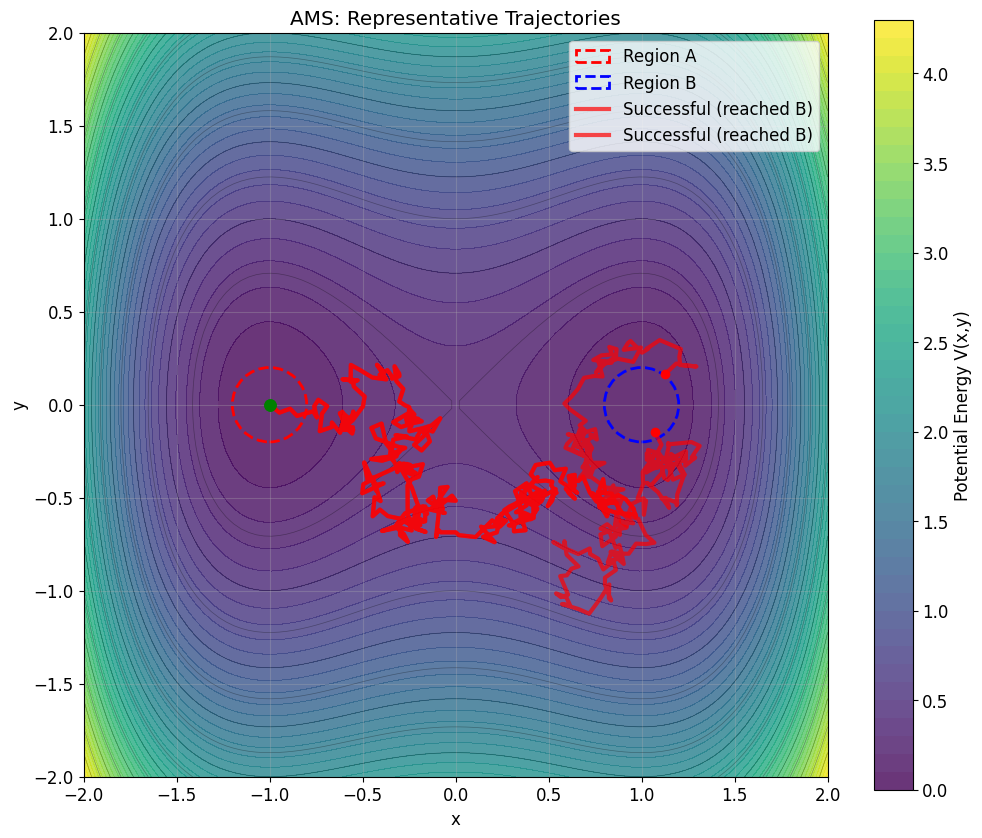

Figure saved to experiments/figures/ams_representative_trajectories.png


In [74]:
def visualize_ams_trajectories(ams, n_trajectories=5):
    """
    Visualize representative trajectories from AMS.
    """
    final_trajectories = ams.trajectories
    final_scores = ams.scores
    
    # Select trajectories to visualize
    # Mix of successful and unsuccessful trajectories
    successful_indices = [i for i, score in enumerate(final_scores) if score == float('inf')]
    progressing_indices = [i for i, score in enumerate(final_scores) 
                          if score != float('inf') and score != float('-inf')]
    
    # Take samples from each category
    vis_indices = []
    if successful_indices:
        vis_indices.extend(np.random.choice(successful_indices, 
                                          min(2, len(successful_indices)), replace=False))
    if progressing_indices:
        vis_indices.extend(np.random.choice(progressing_indices, 
                                          min(3, len(progressing_indices)), replace=False))
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot potential background
    plot_potential_field(omega=1.0, ax=ax, show_regions=True)
    
    # Plot selected trajectories
    colors = ['green', 'blue', 'orange', 'purple', 'brown']
    for i, idx in enumerate(vis_indices[:n_trajectories]):
        traj = final_trajectories[idx]
        score = final_scores[idx]
        
        if score == float('inf'):
            label = f'Successful (reached B)'
            color = 'red'
            linewidth = 3
        elif score == float('-inf'):
            label = f'Failed (returned to A)'
            color = 'gray'
            linewidth = 1
        else:
            label = f'Progressing (max x={score:.2f})'
            color = colors[i % len(colors)]
            linewidth = 2
            
        ax.plot(traj[:, 0], traj[:, 1], color=color, linewidth=linewidth, 
                alpha=0.7, label=label)
        
        # Mark start and end points
        ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=8)
        ax.plot(traj[-1, 0], traj[-1, 1], 'o', color=color, markersize=6)
    
    ax.set_title('AMS: Representative Trajectories')
    ax.legend()
    plt.show()
    
    return fig

# Visualize AMS trajectories
ams_traj_fig = visualize_ams_trajectories(ams, n_trajectories=5)
save_figure(ams_traj_fig, 'ams_representative_trajectories')